<a href="https://colab.research.google.com/github/MaxiPerrone/machine-learning/blob/main/4_Seleccion_modelo_malwares_android.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import zipfile

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score
from pandas import DataFrame

In [ ]:
DRIVE_ZIP_PATH = "/content/drive/MyDrive/datasets/datasets.zip"

drive.mount('/content/drive')

with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall("/content")

Mounted at /content/drive


In [ ]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
  strat = df[stratify] if stratify else None
  train_set, test_set = train_test_split(
      df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
  strat = test_set[stratify] if stratify else None
  val_set, test_set = train_test_split(
      test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
  return (train_set, val_set, test_set)

In [ ]:
def remove_labels(df, label_name):
  X = df.drop(label_name, axis = 1)
  y = df[label_name].copy()
  return (X, y)

In [ ]:
df = pd.read_csv('datasets/TotalFeatures-ISCXFlowMeter.csv')
df.head(5)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
0,1020586,668,1641,35692,2276876,52,52,679,1390,53.431138,...,0.0,-1,0.0,2,4194240,1853440,1640,668,32,benign
1,80794,1,1,75,124,75,124,75,124,75.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
2,998,3,0,187,0,52,-1,83,-1,62.333333,...,0.0,-1,0.0,4,101888,-1,0,3,32,benign
3,189868,9,9,1448,6200,52,52,706,1390,160.888889,...,0.0,-1,0.0,2,4194240,2722560,8,9,32,benign
4,110577,4,6,528,1422,52,52,331,1005,132.000000,...,0.0,-1,0.0,2,155136,31232,5,4,32,benign


In [ ]:
df.shape

(631955, 80)

In [ ]:
df["calss"].value_counts()

,count
calss,
benign,471597
asware,155613
GeneralMalware,4745


In [ ]:
train_set, val_set, test_set = train_val_test_split(df)

In [ ]:
X_train, y_train = remove_labels(train_set, "calss")
X_val, y_val = remove_labels(val_set, "calss")
X_test, y_test = remove_labels(test_set, "calss")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=1, random_state=42)

In [ ]:
y_predict = rf_clf.predict(X_val)

In [ ]:
print("F1 Score ", f1_score(y_predict, y_val, average='weighted'))

F1 Score  0.8948945225444243


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(low=1, high=200),
    'max_depth': randint(low=1, high=50)
}

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=False
)

In [ ]:
X_sample = X_train.sample(frac=0.2, random_state=42)
y_sample = y_train.loc[X_sample.index]

random_search.fit(X_sample[:10000], y_sample[:10000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc67c00baa0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc67c1eac60>},
                   random_state=42, scoring='f1_weighted', verbose=2)

In [ ]:
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print(best_params)
print(best_estimator)

{'max_depth': 19, 'n_estimators': 75}
RandomForestClassifier(max_depth=19, n_estimators=75, n_jobs=-1,
                       random_state=42)


In [ ]:
cv_results = random_search.cv_results_
for score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
  print("F1 Score ", score, ", ", params)

F1 Score  0.8742232849098116 ,  {'max_depth': 39, 'n_estimators': 180}
F1 Score  0.8672083473329265 ,  {'max_depth': 29, 'n_estimators': 15}
F1 Score  0.8724466172200408 ,  {'max_depth': 43, 'n_estimators': 72}
F1 Score  0.8737478865143323 ,  {'max_depth': 21, 'n_estimators': 103}
F1 Score  0.8749997397958276 ,  {'max_depth': 19, 'n_estimators': 75}
F1 Score  0.8732854377358102 ,  {'max_depth': 11, 'n_estimators': 88}
F1 Score  0.8735444513287643 ,  {'max_depth': 36, 'n_estimators': 104}
F1 Score  0.872650585103884 ,  {'max_depth': 24, 'n_estimators': 131}
F1 Score  0.8734687779812118 ,  {'max_depth': 22, 'n_estimators': 53}
F1 Score  0.6935128213709767 ,  {'max_depth': 2, 'n_estimators': 88}


In [ ]:
rf_clf = best_estimator

y_train_predict = rf_clf.predict(X_train)
print("F1 Score ", f1_score(y_train_predict, y_train, average='weighted'))

y_val_predict = rf_clf.predict(X_val)
print("F1 Score ", f1_score(y_val_predict, y_val, average='weighted'))

y_test_predict = rf_clf.predict(X_test)
print("F1 Score ", f1_score(y_test_predict, y_test, average='weighted'))

F1 Score  0.890769254865406
F1 Score  0.8878003699283638
F1 Score  0.8887611193408265


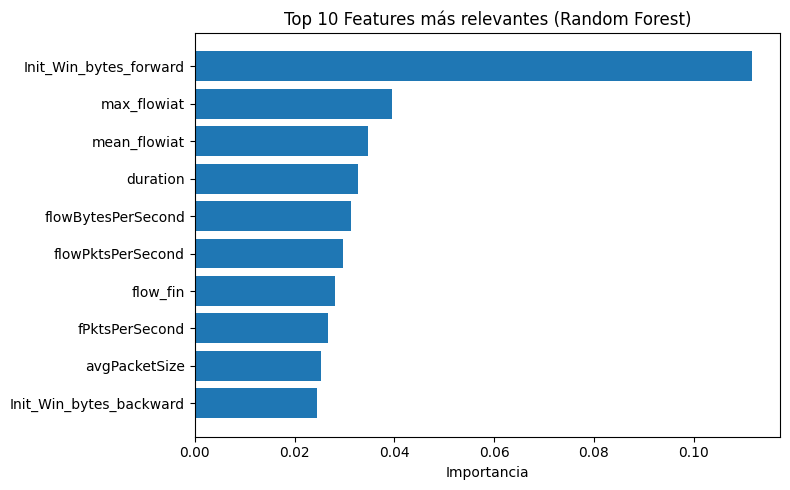

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

importances = rf_clf.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Importancia')
plt.title('Top 10 Features más relevantes (Random Forest)')
plt.tight_layout()
plt.show()
